In [1]:
from diffusers import DiffusionPipeline
import torch

torch.cuda.empty_cache()
pipe = DiffusionPipeline.from_pretrained(
    "playgroundai/playground-v2-1024px-aesthetic",
    torch_dtype=torch.float16,
    use_safetensors=True,
    add_watermarker=False,
    variant="fp16"
)
pipe.to("cuda")

prompt = "Modern Hotel, realistic, detailed"
image  = pipe(prompt=prompt, guidance_scale=3.0).images[0]

image.save("./image.png")

del pipe
torch.cuda.empty_cache()

/home/db/dev/housify/housify-ai-server/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.28it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 7.78 GiB of which 15.38 MiB is free. Including non-PyTorch memory, this process has 5.78 GiB memory in use. Of the allocated memory 5.38 GiB is allocated by PyTorch, and 246.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [2]:
from diffusers import DiffusionPipeline
import torch

del pipe
# load both base & refiner
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
base.to("cuda")
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda")
# refiner.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 40
high_noise_frac = 0.8

prompt = "Modern House Interior"

# run both experts
image = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images
image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]

image.save("./image3.png")
torch.cuda.empty_cache()

text_encoder_2/config.json: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 575/575 [00:00<00:00, 2.59MB/s]

tokenizer/tokenizer_config.json: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 737/737 [00:00<00:00, 3.18MB/s]

tokenizer/special_tokens_map.json: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

OutOfMemoryError: CUDA out of memory. Tried to allocate 122.00 MiB. GPU 0 has a total capacty of 7.78 GiB of which 42.38 MiB is free. Including non-PyTorch memory, this process has 5.78 GiB memory in use. Of the allocated memory 5.38 GiB is allocated by PyTorch, and 246.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

100%|███████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.81it/s]


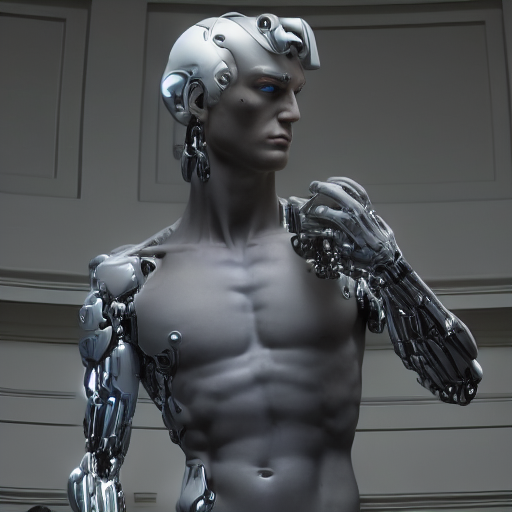

In [9]:
import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"
def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image
image = download_image(url)

prompt = "turn him into cyborg"
images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images
images[0]

In [7]:
from awq import AutoAWQForCausalLM
from transformers import AutoTokenizer
from PIL import Image
import requests

model_name_or_path = "TheBloke/llava-v1.5-13B-AWQ"

# Load model
model = AutoAWQForCausalLM.from_quantized(model_name_or_path, fuse_layers=True,
                                          trust_remote_code=False, safetensors=True)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, trust_remote_code=False)

prompt = "<image>\nUSER: What's the content of the image?\n"
url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw)

print("\n\n*** Generate:")

tokens = tokenizer(
    prompt,
    return_tensors='pt'
).input_ids.cuda()


from transformers import pipeline

print("*** Pipeline:")
pipe = pipeline(
    "image-to-text",
    # prompt=prompt,
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.7,
    top_p=0.95,
    top_k=40,
    repetition_penalty=1.1
)

print(pipe(image,prompt)[0]['generated_text'])

Fusing layers...: 100%|█████████████████████████████████████████| 40/40 [00:02<00:00, 15.78it/s]




*** Generate:
*** Pipeline:


TypeError: ImageToTextPipeline._sanitize_parameters() got an unexpected keyword argument 'do_sample'

In [1]:
from PIL import Image
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration

model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf")
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

prompt = "<image>\nUSER: What's the content of the image?\nASSISTANT:"
url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=prompt, images=image, return_tensors="pt")

# Generate
generate_ids = model.generate(**inputs, max_length=30)
tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

/home/db/housify/housify-ai-server/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.10s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


NameError: name 'tokenizer' is not defined

In [4]:
import requests
from PIL import Image

import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

model_id = "llava-hf/llava-1.5-7b-hf"


# prompt = "<image>\nUSER: What's the content of the image?\nASSISTANT:"
prompt = "<image>\nUSER: Classify the image with no more than 4 words?\nASSISTANT:"

image_file = "http://images.cocodataset.org/val2017/000000039769.jpg"

model = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
    # load_in_4bit=True
).to(0)

processor = AutoProcessor.from_pretrained(model_id)


# raw_image = Image.open(requests.get(image_file, stream=True).raw)
raw_image = Image.open("image3.png")
inputs = processor(prompt, raw_image, return_tensors='pt').to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=4, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))

del model
del processor
torch.cuda.empty_cache()

Loading checkpoint shards: 100%|██████████████████████████████████| 3/3 [00:00<00:00,  9.57it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



USER: Classify the image with no more than 4 words?
ASSISTANT: Living room
